In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import json

In [4]:
df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [11]:
# Mengubah seluruh text kedalam bentuk lowercase
df['sentence'] = df['sentence'].str.lower()

df.head()

,sentence,label
0,wow... loved place.,1
1,crust good.,0
2,tasty texture nasty.,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices.,1


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Menghilangkan stopwords
stop_word = set(stopwords.words('english'))

df['sentence'] = df['sentence'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

df.head()

,sentence,label
0,wow... loved place.,1
1,crust good.,0
2,tasty texture nasty.,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices.,1


In [14]:
#melakukan split dataset
sentence = df['sentence'].values
label = df['label'].values


In [15]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, shuffle=False)

print('Training dataset:\n', sentence_train.shape, label_train.shape)
print('\nTest dataset:\n', sentence_test.shape, label_test.shape)

Training dataset:
 (800,) (800,)

Test dataset:
 (200,) (200,)


In [17]:
#membuat tokenisasi
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(sentence_train)

In [18]:
word_index = tokenizer.word_index
print(len(word_index))

1732


In [19]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

In [20]:
# Membuat sequences dan melakukan padding
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)


train_padded = pad_sequences(train_sekuens,
                             maxlen=20,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=20,
                            padding='post',
                            truncating='post')

In [22]:
train_padded.shape

(800, 20)

In [23]:
test_padded.shape

(200, 20)

In [24]:
#membuat model
model = tf.keras.Sequential([
    Embedding(2000, 20, input_length=20),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            40000     
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43457 (169.75 KB)
Trainable params: 43457 (169.75 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
#Melatih Model
num_epochs = 30
history = model.fit(train_padded, label_train,
                    epochs=num_epochs,
                    validation_data=(test_padded, label_test),
                    verbose=1)

Epoch 1/30
25/25 [==============================] - 2s 20ms/step - loss: 0.6891 - accuracy: 0.5650 - val_loss: 0.7401 - val_accuracy: 0.2400
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.5650 - val_loss: 0.7661 - val_accuracy: 0.2400
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6767 - accuracy: 0.5650 - val_loss: 0.7668 - val_accuracy: 0.2400
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6654 - accuracy: 0.5663 - val_loss: 0.7779 - val_accuracy: 0.2400
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6331 - accuracy: 0.6237 - val_loss: 0.7599 - val_accuracy: 0.3000
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5517 - accuracy: 0.7750 - val_loss: 0.6855 - val_accuracy: 0.4850
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4194 - accuracy: 0.8650 - val_loss: 0.6035 - val_accuracy: 0.6800
Epoch 8/30
25/25 [=

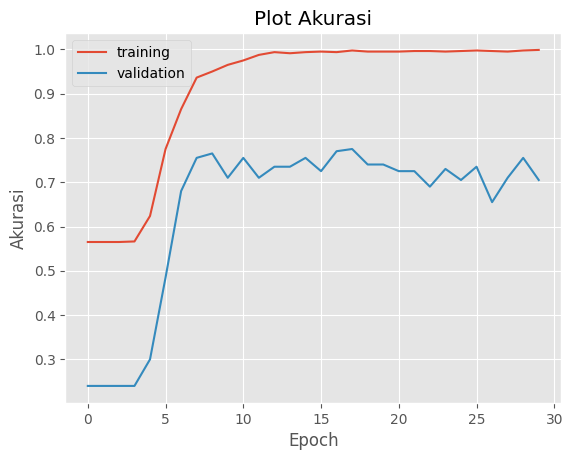

In [28]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.savefig('plot_acc.png')
plt.show()

In [29]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Install tensorflowjs

!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstall

In [31]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2023-12-11 04:04:15.267236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 04:04:15.267318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 04:04:15.268777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 04:04:16.571098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
